In [2]:
# Basics
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# For timing ml algorithms
from timeit import timeit

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

# Saving models
import pickle

In [3]:
# Machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics

In [4]:
# Read dataset files
data_df = pd.read_csv('./dataset/ml_test.csv', index_col=0)

In [5]:
data_df.head()

,review_count,adjusted_stars,price,is_open,caters,goodforkids,alcohol,goodforgroups,tableservice,drivethru,...,pos,compound,revenue,pos_review,neg_review,stars_1.0,stars_2.0,stars_3.0,stars_4.0,stars_5.0
0,0.001342,0.670984,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.535683,0.953855,0.000066,0.005952,0.002024,0.000000,0.007353,0.000000,0.000000,0.006250
1,0.004027,0.678756,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.453430,0.806740,0.000157,0.008929,0.002024,0.000000,0.000000,0.005917,0.006329,0.006250
2,0.004027,0.544041,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.363436,0.598692,0.000079,0.004464,0.010121,0.006154,0.022059,0.000000,0.003165,0.003125
3,0.025503,0.704663,0.333333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.508811,0.909050,0.000931,0.028274,0.010121,0.000000,0.007353,0.011834,0.018987,0.023438
4,0.100671,0.730570,0.333333,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.593778,0.906064,0.006413,0.101190,0.024291,0.009231,0.007353,0.023669,0.025316,0.100000


# Applying Machine Learning
In this machine learning part of the project, I'll be utilizing four different machine learning algorithms in solving classification problem:

1. **Random Forest** (Bagging)
2. **AdaBoost** (use of increasing the weight of misclassified data points)
3. **Gradient Boosting** (learning previous mistakes with residual error)

Based on the result from those three machine learning algorithms, I'll be determining best machine learning algorithm based on accurarcy and computational time.

## Random Forest (Bagging Approach)
My focus is to prevent or minimizing overfitting or having high false positives in the result; therefore, random forest is chosen since it minimizes overfitting and handles large dataset with high dimensionality.

#### Default approach without hyperparameter tuning
I wanted to see baseline result with 100 decision trees created and evaluated through random forest algorithm

In [6]:
# Create X (features) and y (response)
X = data_df[data_df.columns[data_df.columns != "is_open"]]
y = data_df[data_df.columns[data_df.columns == "is_open"]]

# Use train/test split with different random_state values - spliting into for pieces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
%%time

# Instantiate Random Forest Classifier and train the data
rf = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

CPU times: user 5.46 s, sys: 44.2 ms, total: 5.51 s
Wall time: 5.51 s


In [8]:
metrics.accuracy_score(y_test, y_pred)

0.7931034482758621

Random forest algorithm took **5.26 s** in creating and evaluating 100 decision trees with **79%** accuracy without hyperparameter tuning

#### Confusion Matrix
Populating confusion matrix to identify type 1 and type 2 errors

In [9]:
# Creating confusion matrix dataframe
pd.crosstab(y_test['is_open'], y_pred, rownames=['Actual Business Status'], colnames=['Predicted Business Status'])

Predicted Business Status,0.0,1.0
Actual Business Status,,
0.0,2384,1756
1.0,656,6862


#### Initial Precision and Recall
Identify initial sensitivity and specificity values
- recall: all we predicted correctly / all we predicted, correctly or wrongly
- precision: all we predicted correctly / all we should have predicted

In [10]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.58      0.66      4140
         1.0       0.80      0.91      0.85      7518

    accuracy                           0.79     11658
   macro avg       0.79      0.74      0.76     11658
weighted avg       0.79      0.79      0.78     11658



According to initial confusion matrix report, random forest classifier is better at identifying open restaurants compared to close businesses. **42% being false positive** and **8% being false negative**. Since this capstone project is about whether to lend money to the restaurant or whether aspiring restauranteur should open a restaurant. I need to adjust machine learning algorithm to focus on reducing false positives because we don't want to lend or invest in business that will eventually close.

### Selecting the best tuning parameters (aka 'hyperparameters') for Random Forest 
Below are the parameters I'll be tuning using random search cv.

In [11]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

- n_estimators = number of trees in the forest
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [12]:
# Parameters to be used for random search cv
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'criterion': ['gini', 'entropy']}

In [65]:
# Instantiate Random Forest Classifier for tuning
rf = RandomForestClassifier()

# Search across 100 different combinations using all available cores with 3 fold cross validation
random_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 43.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [66]:
random_rf.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': False}

In [67]:
# Seeing random forest classifier
random_rf.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=50,
                       n_estimators=1800)

In [85]:
%%time

rf = random_rf.best_estimator_

rf.fit(X_train,y_train)

# Predict
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Get accuracy score for both train and test sets
print('Train accuracy:', metrics.accuracy_score(y_train, train_preds))
print('Test accuracy:', metrics.accuracy_score(y_test, test_preds))

Train accuracy: 1.0
Test accuracy: 0.8011665808886601
CPU times: user 2min 51s, sys: 960 ms, total: 2min 52s
Wall time: 2min 52s


### Save Random Forest model

In [86]:
filename = "./dataset/random_forest_model.pkl"  

with open(filename, 'wb') as file:  
    pickle.dump(rf, file)

In [80]:
feats = feat_importances.nlargest(20).sort_values(ascending=True).keys().tolist()
feats.append('is_open')

test_df = data_df[feats]
test_df

,tableservice,goodforgroups,goodforkids,review_count,neu,180_days_review_count,90_days_review_count,classy,casual,stars_2.0,...,price,pos,neg,30_days_review_count,adjusted_stars,compound,stars_5.0,revenue,lifespan,is_open
0,0.0,0.0,0.0,0.001342,0.421092,0.00,0.00,0.0,0.0,0.007353,...,0.000000,0.535683,0.091181,0.00,0.670984,0.953855,0.006250,0.000066,0.400396,1.0
1,0.0,0.0,1.0,0.004027,0.478019,0.00,0.00,0.0,0.0,0.000000,...,0.000000,0.453430,0.131860,0.00,0.678756,0.806740,0.006250,0.000157,0.415567,1.0
2,0.0,0.0,0.0,0.004027,0.397783,0.02,0.00,0.0,0.0,0.022059,...,0.000000,0.363436,0.424608,0.02,0.544041,0.598692,0.003125,0.000079,0.038918,0.0
3,1.0,0.0,0.0,0.025503,0.443573,0.05,0.10,0.0,0.0,0.007353,...,0.333333,0.508811,0.097783,0.03,0.704663,0.909050,0.023438,0.000931,0.024406,1.0
4,0.0,1.0,0.0,0.100671,0.365738,0.04,0.03,0.0,1.0,0.007353,...,0.333333,0.593778,0.088238,0.01,0.730570,0.906064,0.100000,0.006413,0.091029,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39819,0.0,1.0,0.0,0.006711,0.488913,0.00,0.00,0.0,0.0,0.007353,...,1.000000,0.310022,0.356876,0.00,0.443005,0.497336,0.000000,0.000695,0.457124,0.0
39820,1.0,1.0,1.0,0.303356,0.426165,0.01,0.06,0.0,1.0,0.058824,...,0.000000,0.506767,0.131571,0.03,0.743523,0.851346,0.198437,0.008538,0.746702,1.0
39821,0.0,1.0,1.0,0.022819,0.553665,0.01,0.00,0.0,1.0,0.022059,...,0.000000,0.295655,0.269738,0.00,0.437824,0.640372,0.001563,0.000341,0.711082,1.0
39822,1.0,1.0,0.0,0.122148,0.412800,0.08,0.04,0.0,0.0,0.088235,...,0.333333,0.531041,0.113417,0.00,0.733161,0.912972,0.081250,0.005049,0.091029,0.0


In [81]:
# Create X (features) and y (response)
X = test_df[test_df.columns[test_df.columns != "is_open"]]
y = test_df[test_df.columns[test_df.columns == "is_open"]]

# Use train/test split with different random_state values - spliting into for pieces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [82]:
%%time

rf = random_rf.best_estimator_

rf.fit(X_train,y_train)

# Predict
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Get accuracy score for both train and test sets
print('Train accuracy:', metrics.accuracy_score(y_train, train_preds))
print('Test accuracy:', metrics.accuracy_score(y_test, test_preds))

Train accuracy: 1.0
Test accuracy: 0.7785211871676102
CPU times: user 2min 22s, sys: 642 ms, total: 2min 23s
Wall time: 2min 23s


## OVERFITTING for RANDOM FOREST

## Understanding feature importance (Gini)

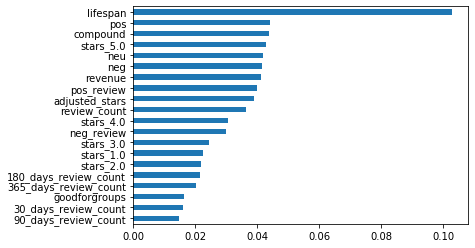

In [13]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(20).sort_values(ascending=True)
feat_importances.plot(kind='barh');

## AdaBoost
Tested with AdaBoost algorithm to inspect how well it performs when we focus on what the model misclassifies through **sampling distribution**.

#### Default approach without hyperparameter tuning
Inspecting baseline when AdaBoost is used without tuning with the exception n_estimators (how many stumps we like to create).

In [14]:
%%time

ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)

CPU times: user 5.49 s, sys: 176 ms, total: 5.67 s
Wall time: 5.67 s


In [15]:
metrics.accuracy_score(y_test, y_pred)

0.7635958140332819

AdaBoost algorithm took **5.45 s** in creating and evaluating 100 decision trees with **76%** accuracy without hyperparameter tuning.

In [55]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65      4140
         1.0       0.79      0.90      0.84      7518

    accuracy                           0.78     11658
   macro avg       0.78      0.73      0.75     11658
weighted avg       0.78      0.78      0.77     11658



In [17]:
# Creating confusion matrix dataframe
pd.crosstab(y_test['is_open'], y_pred, rownames=['Actual Business Status'], colnames=['Predicted Business Status'])

Predicted Business Status,0.0,1.0
Actual Business Status,,
0.0,2460,1680
1.0,1076,6442


Overall AdaBoost provided less desirable result compared to random forest classifier since AdaBoost had higher false negative at **14%**. However, it did provide lower false positives at **40.5%**, decrease from **42%**.

### Selecting the best tuning parameters for AdaBoost 
Will be using GridSearchCV for optimization by tuning the following parameters below:

- **n_estimators**: maximum number of estimators (stumps at which boosting is terminated
- **learning_rate**: rate at which we are adjusting the weights of our model with respect to the loss gradient

In [18]:
# Hyperparameters for tuning
param_grid = {
    'n_estimators': [100,200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]
}

In [19]:
# Instantiate AdaBoost Classifier for tuning
ada_clf = AdaBoostClassifier()

# Intantiate GridSearchCV
gs_ada_clf = GridSearchCV(ada_clf, param_grid=param_grid)

#### Fit and predict based on AdaBoost's adjusted parameters

In [20]:
%%time

# Fit model
gs_ada_clf.fit(X_train, y_train)

# Predict
train_preds = gs_ada_clf.predict(X_train)
test_preds = gs_ada_clf.predict(X_test)

# Get accuracy score for both train and test sets
print('Train accuracy:', metrics.accuracy_score(y_train, train_preds))
print('Test accuracy:', metrics.accuracy_score(y_test, test_preds))

Train accuracy: 0.7773529411764706
Test accuracy: 0.770372276548293
CPU times: user 5min 15s, sys: 2.07 s, total: 5min 17s
Wall time: 5min 17s


In [21]:
# Creating confusion matrix dataframe
pd.crosstab(y_test['is_open'], test_preds, rownames=['Actual Business Status'], colnames=['Predicted Business Status'])

Predicted Business Status,0.0,1.0
Actual Business Status,,
0.0,2424,1716
1.0,961,6557


#### Identifying best parameters and features for AdaBoost

In [22]:
gs_ada_clf.best_estimator_

AdaBoostClassifier(learning_rate=0.5, n_estimators=200)

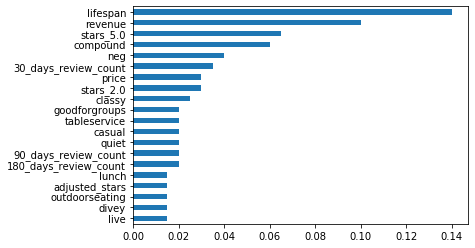

In [23]:
feat_importances = pd.Series(gs_ada_clf.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(20).sort_values(ascending=True)
feat_importances.plot(kind='barh');

### AdaBoost Summary
Initial AdaBoost algorithm with default setting took **5.45 s** in creating and evaluating 100 decision trees with **76%** accuracy which is lower than Random Forest's initial accuracy. However it did provide lower false positives at **40.5%**, decrease from **42%**. I tuned its hyperparameters using GridSearchCV adjusting **n_estimators at 200** with **learning_rate of 0.5**.

It yielded better overall result at **77%** getting better result at obtaining higher true negatives but at the expense of gaining more false positives.

## Gradient Boosting
Learns from the mistake - residual error directly, instead learning from weights of the data points.

In [24]:
%%time

grad_clf = GradientBoostingClassifier(n_estimators=100)
grad_clf.fit(X_train, y_train)
y_pred = grad_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7834105335392005
CPU times: user 11.8 s, sys: 42 ms, total: 11.8 s
Wall time: 11.8 s


In [25]:
# Creating confusion matrix dataframe
pd.crosstab(y_test['is_open'], y_pred, rownames=['Actual Business Status'], colnames=['Predicted Business Status'])

Predicted Business Status,0.0,1.0
Actual Business Status,,
0.0,2347,1793
1.0,732,6786


In [26]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65      4140
         1.0       0.79      0.90      0.84      7518

    accuracy                           0.78     11658
   macro avg       0.78      0.73      0.75     11658
weighted avg       0.78      0.78      0.77     11658



Gradient boosting did better at predicting open and closed restaurants than AdaBoost but did poorer than Random Forest, similar to all algorithms - It did not do very good job at predicting closed restaurants - instead it misclassified closed restaurants as open. It has the highest false positives (**43%**) compared to other algorithms. Overall it has initial accuracy at **78%**.

### Selecting the best tuning parameters for Gradient Boosting
Same as AdaBoost, I will be using GridSearchCV for optimization by tuning the following parameters below:

- **n_estimators**: maximum number of estimators (stumps at which boosting is terminated
- **learning_rate**: rate at which we are adjusting the weights of our model with respect to the loss gradient

In [27]:
# Hyperparameters for tuning
param_grid = {
    'n_estimators': [100,200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]
}

In [28]:
# Instantiate Gradient Boosting Classifier for tuning
grad_clf = GradientBoostingClassifier()

# Intantiate GridSearchCV
gs_grad_clf = GridSearchCV(grad_clf, param_grid=param_grid)

#### Fit and predict based on Gradient Boosting's adjusted parameters

In [29]:
%%time

# Fit model
gs_grad_clf.fit(X_train, y_train)

# Predict
train_preds = gs_grad_clf.predict(X_train)
test_preds = gs_grad_clf.predict(X_test)

# Get accuracy score for both train and test sets
print('Train accuracy:', metrics.accuracy_score(y_train, train_preds))
print('Test accuracy:', metrics.accuracy_score(y_test, test_preds))

Train accuracy: 0.8335661764705883
Test accuracy: 0.7997941327843541
CPU times: user 10min 2s, sys: 1.35 s, total: 10min 3s
Wall time: 10min 3s


In [30]:
# Creating confusion matrix dataframe
pd.crosstab(y_test['is_open'], test_preds, rownames=['Actual Business Status'], colnames=['Predicted Business Status'])

Predicted Business Status,0.0,1.0
Actual Business Status,,
0.0,2612,1528
1.0,806,6712


#### Identifying best parameters and features for Gradient Boosting

In [31]:
gs_grad_clf.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, n_estimators=200)

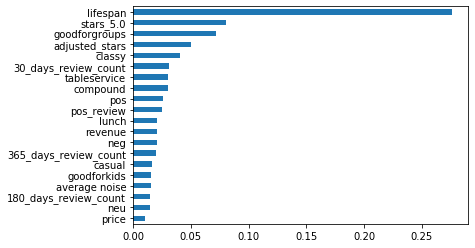

In [32]:
feat_importances = pd.Series(gs_grad_clf.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(20).sort_values(ascending=True)
feat_importances.plot(kind='barh');

### Gradient Boosting Summary
Initial GradientBoosting algorithm with default setting took **9.24 s** in creating and evaluating 100 decision trees with **78%** accuracy which is lower than Random Forest's initial accuracy but higher than AdaBoost's accurracy. However it did provided highest false positives at **43%**. I tuned its hyperparameters using GridSearchCV adjusting **n_estimators at 200** with **learning_rate of 0.2**.

It yielded best overall accuracy result at **79.9%** and getting least false positives at **36.9%**. So far, I would recommend using gradient boosting as it has lower chance of lending or investing on businesses that is going to fail.

In [36]:
# pd.read_pickle method 
random_rf = pd.read_pickle('./dataset/random_forest_model.pkl')

## ROC and AUC
To visually see which machine learning algorithm performed the best.

### Prediction probabilities

In [42]:
r_probs = [0 for _ in range(len(y_test))] # baseline
grad_clf_probs = gs_grad_clf.predict_proba(X_test)
ada_clf_probs = gs_ada_clf.predict_proba(X_test)
rf_probs = random_rf.predict_proba(X_test)

### Probabilities for the positive outcome

In [43]:
grad_clf_probs = grad_clf_probs[:, 1]
ada_clf_probs = ada_clf_probs[:, 1]
rf_probs = rf_probs[:, 1]

### Computing AUROC and ROC curve values

In [45]:
r_auc = metrics.roc_auc_score(y_test, r_probs)
grad_clf_auc = metrics.roc_auc_score(y_test, grad_clf_probs)
ada_clf_auc = metrics.roc_auc_score(y_test, ada_clf_probs)
rf_auc = metrics.roc_auc_score(y_test, rf_probs)

### AUROC scores

In [47]:
print(f'Random Forest: AUROC {rf_auc}')
print(f'AdaBoost: AUROC {ada_clf_auc}')
print(f'Gradient Boosting: AUROC {grad_clf_auc}')ro
print(f'Random chance prediction: AUROC {r_auc}')

Random Forest: AUROC 0.860920827052112
AdaBoost: AUROC 0.8279969136873435
Gradient Boosting: AUROC 0.8607765196057643
Random chance prediction: AUROC 0.5


### Calculate ROC curve and Plot

In [52]:
r_fpr, r_tpr, _ = metrics.roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, rf_probs)
ada_fpr, ada_tpr, _ = metrics.roc_curve(y_test, ada_clf_probs)
grad_fpr, grad_tpr, _ = metrics.roc_curve(y_test, grad_clf_probs)

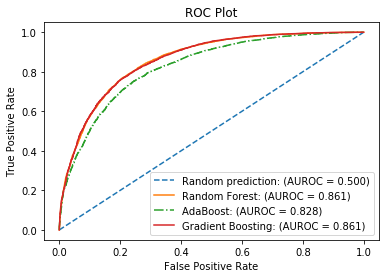

In [54]:
plt.plot(r_fpr, r_tpr, linestyle='--', label= 'Random prediction: (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, linestyle='-', label= 'Random Forest: (AUROC = %0.3f)' % rf_auc)
plt.plot(ada_fpr, ada_tpr, linestyle='-.', label= 'AdaBoost: (AUROC = %0.3f)' % ada_clf_auc)
plt.plot(grad_fpr, grad_tpr, linestyle='solid', label= 'Gradient Boosting: (AUROC = %0.3f)' % grad_clf_auc)

plt.title('ROC Plot') # Title
plt.xlabel('False Positive Rate') # Axis labels
plt.ylabel('True Positive Rate')
plt.legend() # Show legend
plt.show() 

### Summary
Random forest and Gradient Boosting algorithm gave the best outcome in predicting whether restaurants are open or closed based on given features. Each algorithms had differing feature importance but few features repeatedly came into view such as lifespan, sentiment score, star rating, revenue, and review count. Those five features are important in determining whether restaurant will strive or fail in hospitality industry.